In [2]:
import pandas as pd
import json
import requests
import geopandas as gpd
from shapely.geometry import box, Polygon
from tqdm import tqdm_notebook

In [8]:
dates = requests.get('https://openaltimetry.org/data/icesat2/getTrackDate').json()
tracks = gpd.read_file(r"../data/icesat-2/icesat2_tracks.shp")

crs = {'init': 'epsg:4326'}
extents = [5.35,53.4,6.2,53.5]
polygon_geom = Polygon(zip([extents[0],extents[2],extents[2],extents[0]], [extents[1],extents[1],extents[3],extents[3]]))
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       

# Clip data
tracks_clip = gpd.clip(tracks, polygon)
trackids = tracks_clip.TrackId.values

import folium
m = folium.Map([53.3,6.1], zoom_start=10, tiles='cartodbpositron')
folium.GeoJson(polygon).add_to(m)
folium.GeoJson(tracks_clip).add_to(m)
folium.LatLngPopup().add_to(m)
m

C:\Users\lugt\.conda\envs\globath\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lugt\.conda\envs\globath\lib\site-packages\geopandas\geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [9]:
for trackid in trackids:
    Datadic = {}
    dateslist = dates['track_{}'.format(trackid)].split(',')
    
    for date in dateslist:
        print(trackid, date)
        # Paste the OpenAltimetry API URL for Photon here: 
        OA_API_URL = 'https://openaltimetry.org/data/api/icesat2/atl03?&minx={}&miny={}&maxx={}&maxy={}&date={}&trackId={}&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l' \
                    .format(extents[0],extents[1],extents[2],extents[3],date,trackid)

        # Select the list of confidence to display: 'Noise', 'Buffer', 'Low', 'Medium', 'High'
        OA_PHOTON_CONFIDENCE = ['Medium', 'High']
        df_beams = []

        # This function will request the 6 beams data using OpenAltimetry's API
        def getPhotonData(OA_API_URLi):
            series = []
            b_url = OA_API_URLi + '&client=jupyter'
            print('Requesting data from OA')
            r = requests.get(b_url)
            data = r.json()
            return data

        photon_cloud = getPhotonData(OA_API_URL)
        for beam in photon_cloud:
            print('Reading data for beam: ' + beam['beam_name'])
            for photons in beam['series']:
                if any(word in photons['name'] for word in OA_PHOTON_CONFIDENCE):
                    series = []
                    for p in photons['data']:
                        series.append({'lat': p[0],'lon': p[1],'h': p[2]})
                    if (len(series) > 0):
                        print('Available')
                        df = pd.DataFrame.from_dict(series)
                        df.name = beam['beam_name'] + ' ' + photons['name']
                        df_beams.append(df)
                        
        Datadic['ID_{}_{}'.format(trackid, date)] = df_beams

252 2018-10-15
Requesting data from OA
Reading data for beam: gt3r
Reading data for beam: gt3l
Reading data for beam: gt2r
Reading data for beam: gt2l
Reading data for beam: gt1r
Reading data for beam: gt1l
252 2019-01-13
Requesting data from OA
Reading data for beam: gt3r
Available
Available
Reading data for beam: gt3l
Available
Available
Reading data for beam: gt2r
Available
Available
Reading data for beam: gt2l
Available
Available
Reading data for beam: gt1r
Available
Available
Reading data for beam: gt1l
Available
Available
252 2019-01-14
Requesting data from OA
Reading data for beam: gt3r
Reading data for beam: gt3l
Reading data for beam: gt2r
Reading data for beam: gt2l
Reading data for beam: gt1r
Reading data for beam: gt1l
252 2019-04-14
Requesting data from OA
Reading data for beam: gt3r
Available
Available
Reading data for beam: gt3l
Available
Available
Reading data for beam: gt2r
Available
Available
Reading data for beam: gt2l
Available
Available
Reading data for beam: gt1r


In [3]:
import pickle
#with open('Datadic_ameland.pickle', 'wb') as handle:
#    pickle.dump(Datadic, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Datadic_ameland.pickle', 'rb') as handle:
    Datadic = pickle.load(handle)    

<IPython.core.display.Javascript object>


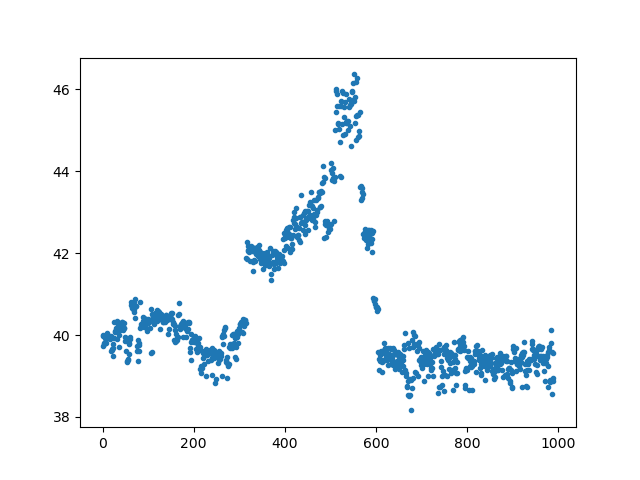

<IPython.core.display.Javascript object>


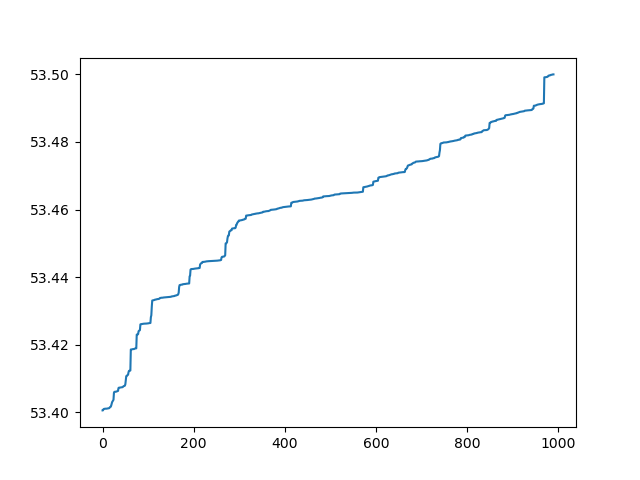

In [4]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
plt.figure()
plt.plot(Datadic['ID_1357_2019-03-27'][0]['h'], '.')
plt.figure()
plt.plot(Datadic['ID_1357_2019-03-27'][0]['lat'])


<IPython.core.display.Javascript object>


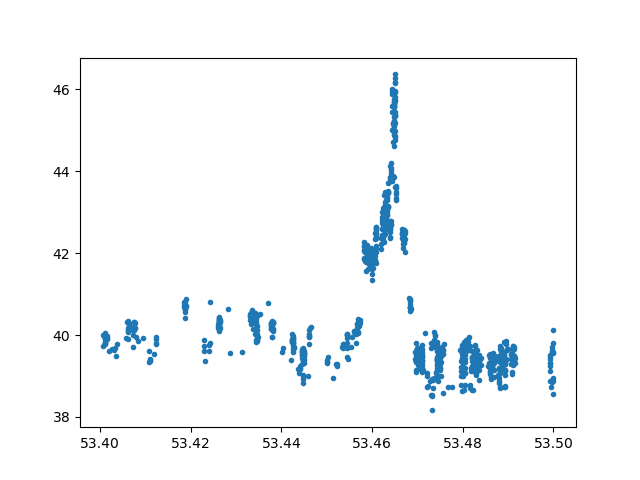

In [15]:
%matplotlib notebook
plt.figure()
plt.plot(Datadic['ID_1357_2019-03-27'][0]['lat'],Datadic['ID_1357_2019-03-27'][0]['h'], '.')

Perform smoothing of the signal with quadratic loess smoothing, 
(distance weighted smoothing with range labda)
only return values where sufficient pings are present.

In [5]:
#%% definitions
def quadraticsurface(beta,x):
    a0, a1, a2 = beta
    
    z = a0*x + a1*x*x + a2
        
    return z

def linearsurface(beta,x):
    a0, a1 = beta
    
    z = a0*x + a1
        
    return z

def quadratic_loes_interp(x,xjes,zjes,wjes):
        x = x-xjes.min()
        xjes = xjes - xjes.min()
        WW = np.diag(wjes)
        
        #make matrix with samples in distance range for quadratic samples
        XX = np.concatenate([[xjes],[xjes**2],[np.ones_like(xjes)]]).T   
        
        #find parameter factor beta for the quadratic surface in closed-form expression by 
        #minimizing the sum of squared residuals including the weight matrix
        XtwX = np.dot(np.dot(XX.transpose(),WW),XX)
        XtwXinv = np.linalg.inv(XtwX)
        OLSbeta=np.dot(np.dot(np.dot(XtwXinv,XX.transpose()),WW),zjes)    
        
        # interpolate the quadratic regression to the inference point
        z_interp = quadraticsurface(OLSbeta,x)
        
        return z_interp
    
def linear_loes_interp(x,xjes,zjes,wjes):        
        
        WW = np.diag(wjes)
        
        #make matrix with samples in distance range for quadratic samples
        XX = np.concatenate([[xjes],[np.ones_like(xjes)]]).T    
        
        #find parameter factor beta for the linear surface in closed-form expression by 
        #minimizing the sum of squared residuals including the weight matrix
        
        XtwX = np.dot(np.dot(XX.transpose(),WW),XX)
        XtwXinv = np.linalg.inv(XtwX)
        OLSbeta=np.dot(np.dot(np.dot(XtwXinv,XX.transpose()),WW),zjes) 
        
        # interpolate the quadratic regression to the inference point
        z_interp = linearsurface(OLSbeta,x)  
        
        return z_interp

def linear_interp(x,xjes,zjes):

        #make matrix with samples in distance range for quadratic samples
        XX = np.concatenate([[xjes],[np.ones_like(xjes)]]).T 
        
        #find parameter factor beta for the linear surface in closed-form expression by 
        #minimizing the sum of squared residuals 
        XtX = np.dot(XX.transpose(),XX)
        XtXinv = np.linalg.inv(XtX)
        OLSbeta=np.dot(np.dot(XtXinv,XX.transpose()),zjes)    
        
        # interpolate the quadratic regression to the inference point
        z_interp = linearsurface(OLSbeta,x) 
        
        return z_interp

<IPython.core.display.Javascript object>


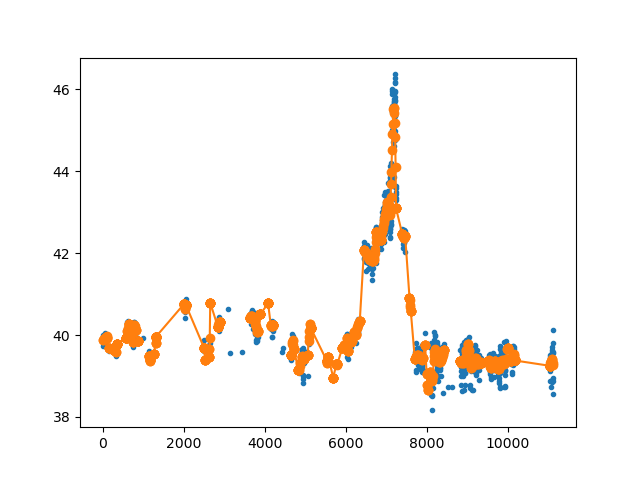

In [25]:
from geopy.distance import geodesic
import numpy as np

# desired resolution(euclidean)
dx = 10

#define length scales over which points are taken into account
labda = 100

# make an array in euclidean space where the smoothing is performed, 
#and modify such that exact lon,lat coordinates are known.
lat = Datadic['ID_1357_2019-03-27'][0]['lat']
lon = Datadic['ID_1357_2019-03-27'][0]['lon']
d   = np.array([geodesic((lat[ip],lon[ip]),(lat[0],lon[0])).m for ip in np.arange(0,len(lat))]) 
x0 = np.arange(0,np.max(d),dx)
ilatlon = [np.abs(ix-d).argmin() for ix in x0]
x = d[ilatlon]
latx = lat[ilatlon]
lonx = lon[ilatlon] 
    
#initialize the array with interpolated Zjes
z   = np.array(Datadic['ID_1357_2019-03-27'][0]['h'])
z_interp = np.nan*np.ones_like(x);

for ixy in range(0,x.size):    
    #remove all data from dependence matrix with zero weights to speed up
    dx = np.abs(x[ixy]-d)
    normdist = dx/labda
    idx = normdist <=1
    
    if not idx.sum() < 3:         
        w = np.zeros_like(dx)
        w[idx] = np.power(1.0 - np.power(np.abs(normdist[idx]), 3), 3)
               
        z_interp[ixy] = quadratic_loes_interp(x[ixy],d[idx],z[idx],w[idx])
#        z_interp[ixy] = linear_loes_interp(x[ixy],d[idx],z[idx],w[idx])
#        z_interp[ixy] = linear_interp(x[ixy],d[idx],z[idx])  
        
        
# plot interpolated topography
fig, ax = plt.subplots()
plt.plot(d,z,'.')
plt.plot(x,z_interp,'o-')